# Udacity Self Driving Car
## Term 1. Vehicle detection and tracking

The goal of this project is to identify and track vehicles in a video from a front-facing camera on a car. This project applies traditional computer vision technique such as Histogram of Oriented Gradients and other features to track vehicles in the video using sliding windows approach.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
import glob
import time
import pickle

from sklearn.svm import SVC, LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from random import shuffle
from scipy.ndimage.measurements import label

# import libraries needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

from matplotlib import gridspec
% matplotlib inline

In [2]:
# load training data
car_images_names = glob.glob('vehicles/**/*.png')
noncar_images_names = glob.glob('non-vehicles/**/*.png')
print('number of vehicle images: %d, number of non-vehicles images: %d' % \
      (len(car_images_names), len(noncar_images_names)))

number of vehicle images: 8792, number of non-vehicles images: 8968


In [3]:
car_images_names_train = car_images_names[:int(0.7 * len(car_images_names))]
car_images_names_val = car_images_names[int(0.7 * len(car_images_names)):int(0.9 * len(car_images_names))]
car_images_names_test = car_images_names[int(0.9 * len(car_images_names)):]

noncar_images_names_train = noncar_images_names[:int(0.7 * len(noncar_images_names))]
noncar_images_names_val = noncar_images_names[int(0.7 * len(noncar_images_names)):int(0.9 * len(noncar_images_names))]
noncar_images_names_test = noncar_images_names[int(0.9 * len(noncar_images_names)):]

In [4]:
print('number of vehicle images - training set: %d, validation set: %d, test set: %d' % \
      (len(car_images_names_train), len(car_images_names_val),len(car_images_names_test)))

print('number of vehicle images - training set: %d, validation set: %d, test set: %d' % \
      (len(noncar_images_names_train), len(noncar_images_names_val),len(noncar_images_names_test)))

number of vehicle images - training set: 6154, validation set: 1758, test set: 880
number of vehicle images - training set: 6277, validation set: 1794, test set: 897


In [5]:
# we have a balanced dataset, let's save the data
data_pickle = {}
data_pickle['cars_train'] = car_images_names_train
data_pickle['cars_val'] = car_images_names_val
data_pickle['cars_test'] = car_images_names_test

data_pickle['noncars_train'] = noncar_images_names_train
data_pickle['noncars_val'] = noncar_images_names_val
data_pickle['noncars_test'] = noncar_images_names_test

pickle.dump(data_pickle, open('./data_pickle.p', 'wb'))

In [6]:
# Read in camera calibration matrix and distortion parameters
data_pickle = pickle.load(open('./data_pickle.p', 'rb'))
car_images_names_train = data_pickle['cars_train']
car_images_names_val = data_pickle['cars_val']
car_images_names_test = data_pickle['cars_test']

noncar_images_names_train = data_pickle['noncars_train']
noncar_images_names_val  = data_pickle['noncars_val']
noncar_images_names_test = data_pickle['noncars_test'] 

# Data Visualization

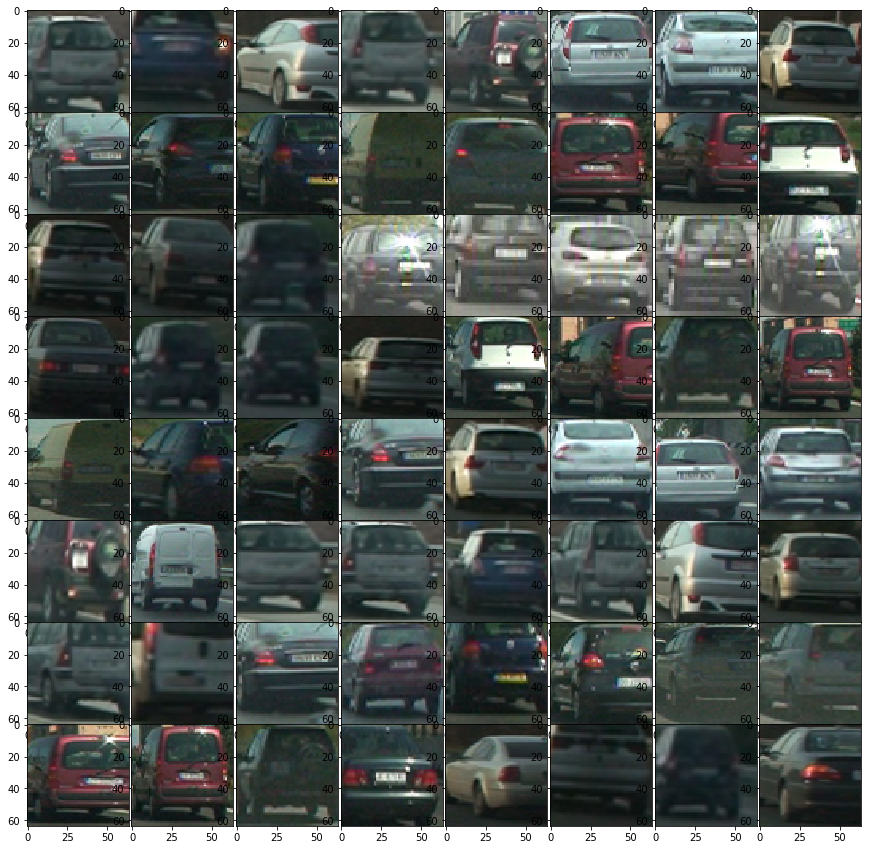

In [7]:
# Visualize vehicle images
grid_spec = gridspec.GridSpec(8,8)
fig = plt.figure(figsize = (15,15))
for i in range(8):
    for j in range(8):
        plt.subplot(grid_spec[i,j])
        car_image = mpimg.imread(car_images_names[i*8+j])
        plt.imshow(car_image)
plt.subplots_adjust(wspace=0, hspace=0)        

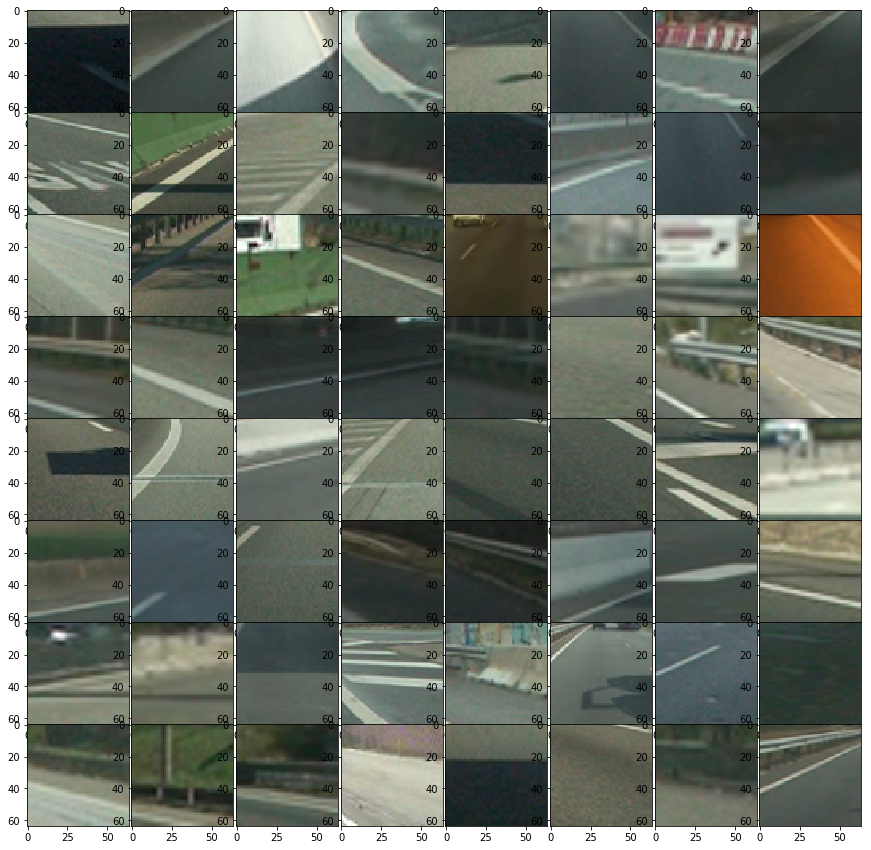

In [8]:
# Visualize non-vehicle images
grid_spec = gridspec.GridSpec(8,8)
fig = plt.figure(figsize = (15,15))
for i in range(8):
    for j in range(8):
        plt.subplot(grid_spec[i,j])
        car_image = mpimg.imread(noncar_images_names[i*8+j])
        plt.imshow(car_image)
plt.subplots_adjust(wspace=0, hspace=0)

## Extract features 

Text(0.5,1,'Example Non-Vehicle Image')

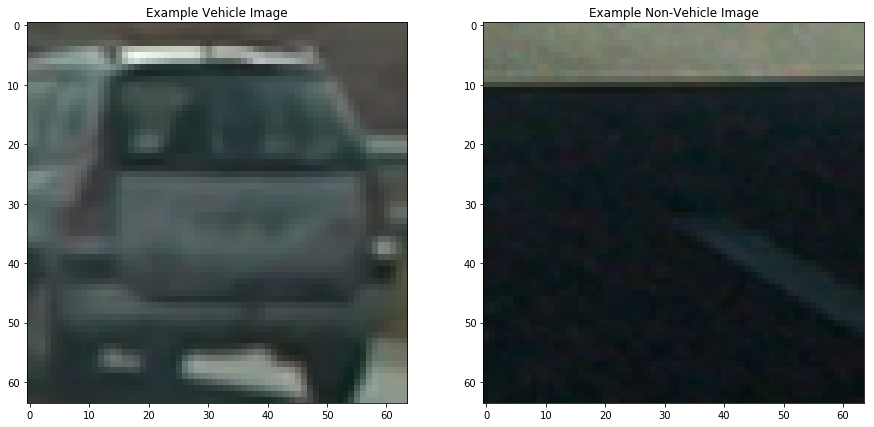

In [9]:
# examples of vehicle and non-vehicle images 
car_image = mpimg.imread(car_images_names[0])
noncar_image = mpimg.imread(noncar_images_names[0])

fig = plt.figure(figsize = (15,15))
plt.subplot(121)
plt.imshow(car_image)
plt.title('Example Vehicle Image')
plt.subplot(122)
plt.imshow(noncar_image)
plt.title('Example Non-Vehicle Image')

## Extract HOG features

In [10]:
# Adapted from the lecture
# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features

In [11]:
# matplotlib image reads .png on a scale 0 to 1, but cv2.imread() reads .png on a scale 0 to 255!
print(np.max(car_image), np.max(cv2.imread(car_images_names[0])))

0.99215686 253


In [12]:
# matplotlib image reads .jpg on a scale 0 to 255, but cv2.imread() reads .jpg on a scale 0 to 255!
print(np.max(mpimg.imread('test_images/test1.jpg')), np.max(cv2.imread('test_images/test1.jpg')))

255 255


Text(0.5,1,'Non Car HOG')

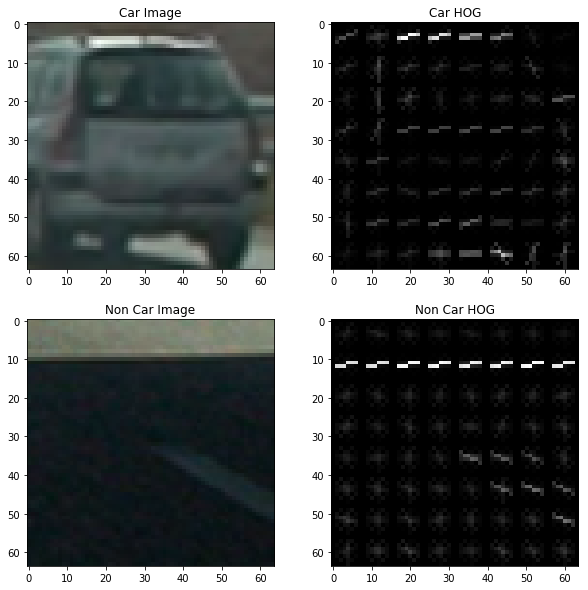

In [13]:
car_gray = cv2.cvtColor(car_image, cv2.COLOR_RGB2GRAY)
noncar_gray = cv2.cvtColor(noncar_image, cv2.COLOR_RGB2GRAY)

# Define HOG parameters
orient = 9
pix_per_cell = 8
cell_per_block = 2

# Call our function with vis=True to see an image output for vehicle
_, car_hog_image = get_hog_features(car_gray, orient, 
                        pix_per_cell, cell_per_block, 
                        vis=True, feature_vec=False)

# Call our function with vis=True to see an image output for non-vehicle
_, noncar_hog_image = get_hog_features(noncar_gray, orient, 
                        pix_per_cell, cell_per_block, 
                        vis=True, feature_vec=False)


# Plot the examples
fig = plt.figure(figsize = (10,10))
plt.subplot(221)
plt.imshow(car_image)
plt.title('Car Image')
plt.subplot(222)
plt.imshow(car_hog_image, cmap='gray')
plt.title('Car HOG')
plt.subplot(223)
plt.imshow(noncar_image)
plt.title('Non Car Image')
plt.subplot(224)
plt.imshow(noncar_hog_image, cmap='gray')
plt.title('Non Car HOG')

## Extract Color features

In [14]:
# Adapted from lecture
# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

# Define a function to compute color histogram features  
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_color_features(imgs, cspace='RGB', spatial_size=(32, 32),
                        hist_bins=32, hist_range=(0, 256)):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if cspace != 'RGB':
            if cspace == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif cspace == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif cspace == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif cspace == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif cspace == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)    
                
        else: feature_image = np.copy(image)      
        # Apply bin_spatial() to get spatial color features
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        # Apply color_hist() also with a color space option now
        hist_features = color_hist(feature_image, nbins=hist_bins, bins_range=hist_range)
        # Append the new feature vector to the features list
        features.append(np.concatenate((spatial_features, hist_features)))
    # Return list of feature vectors
    return features

In [15]:
spatial = 16
histbin = 32

car_color_features_train = extract_color_features(car_images_names_train, cspace='YCrCb', spatial_size=(spatial, spatial),
                        hist_bins=histbin, hist_range=(0, 256))
car_color_features_val = extract_color_features(car_images_names_val, cspace='YCrCb', spatial_size=(spatial, spatial),
                        hist_bins=histbin, hist_range=(0, 256))
car_color_features_test = extract_color_features(car_images_names_test, cspace='YCrCb', spatial_size=(spatial, spatial),
                        hist_bins=histbin, hist_range=(0, 256))

notcar_color_features_train = extract_color_features(noncar_images_names_train, cspace='YCrCb', spatial_size=(spatial, spatial),
                        hist_bins=histbin, hist_range=(0, 256))
notcar_color_features_val = extract_color_features(noncar_images_names_val, cspace='YCrCb', spatial_size=(spatial, spatial),
                        hist_bins=histbin, hist_range=(0, 256))
notcar_color_features_test = extract_color_features(noncar_images_names_test, cspace='YCrCb', spatial_size=(spatial, spatial),
                        hist_bins=histbin, hist_range=(0, 256))

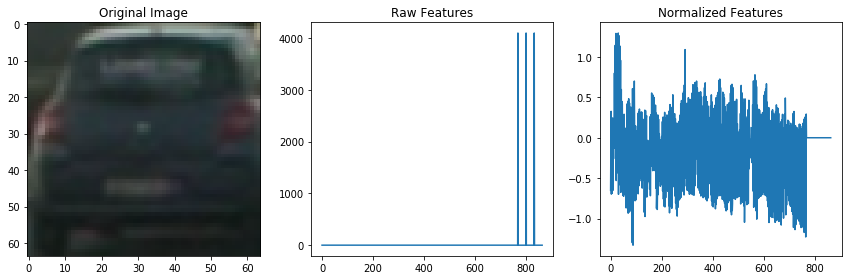

In [16]:
if len(car_color_features_train) > 0:
    # Create an array stack of feature vectors
    X = np.vstack((car_color_features_train, notcar_color_features_train)).astype(np.float64)                        
    # Fit a per-column scaler
    X_scaler = StandardScaler().fit(X)
    # Apply the scaler to X
    scaled_X = X_scaler.transform(X)
    car_ind = np.random.randint(0, len(car_color_features_train))
    # Plot an example of raw and scaled features
    fig = plt.figure(figsize=(12,4))
    plt.subplot(131)
    plt.imshow(mpimg.imread(car_images_names_train[car_ind]))
    plt.title('Original Image')
    plt.subplot(132)
    plt.plot(X[car_ind])
    plt.title('Raw Features')
    plt.subplot(133)
    plt.plot(scaled_X[car_ind])
    plt.title('Normalized Features')
    fig.tight_layout()
else: 
    print('Your function only returns empty feature vectors...')

## Data preprocessing and Color Classify

In [17]:
# Define the labels vector
X_train = np.vstack((car_color_features_train, notcar_color_features_train)).astype(np.float64)
X_val = np.vstack((car_color_features_val, notcar_color_features_val)).astype(np.float64)
X_test = np.vstack((car_color_features_test, notcar_color_features_test)).astype(np.float64)

y_train = np.hstack((np.ones(len(car_color_features_train)), np.zeros(len(notcar_color_features_train))))
y_val = np.hstack((np.ones(len(car_color_features_val)), np.zeros(len(notcar_color_features_val))))
y_test = np.hstack((np.ones(len(car_color_features_test)), np.zeros(len(notcar_color_features_test))))

# # Split up data into randomized training and test sets
# rand_state = np.random.randint(0, 100)
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=rand_state)

# Fit a per-column scaler only on the traing data 
X_scaler = StandardScaler().fit(X_train)

# Apply the scaler to both X_train and X_test
scaled_X_train = X_scaler.transform(X_train)
scaled_X_val = X_scaler.transform(X_val)
scaled_X_test = X_scaler.transform(X_test)

print('Using spatial binning of:',spatial,
    'and', histbin,'histogram bins')
print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 
svc = LinearSVC(C = 0.001)
# Check the training time for the SVC
t=time.time()
svc.fit(scaled_X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')

# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(scaled_X_val, y_val), 4))

# Check the prediction time for a single sample
t=time.time()
n_predict = 10

print('My SVC predicts: ', svc.predict(scaled_X_val[0:n_predict]))
print('For these',n_predict, 'labels: ', y_val[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

Using spatial binning of: 16 and 32 histogram bins
Feature vector length: 864
1.89 Seconds to train SVC...
Test Accuracy of SVC =  0.9296
My SVC predicts:  [1. 1. 1. 1. 1. 1. 1. 0. 1. 1.]
For these 10 labels:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
0.0026 Seconds to predict 10 labels with SVC


In [18]:
# # perform cross-validation
# parameters = {'kernel':('linear', 'rbf'), 'C':[1, 10]}
# svr = SVC()
# clf = GridSearchCV(svr, parameters)
# clf.fit(scaled_X_train, y_train)
# clf.best_params_

In [19]:
# Check the score of the SVC on the test set
print('Test Accuracy of SVC = ', round(svc.score(scaled_X_test, y_test), 4))

# Check the prediction time for a single sample
t=time.time()
n_predict = 10

print('My SVC predicts: ', svc.predict(scaled_X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

Test Accuracy of SVC =  0.9201
My SVC predicts:  [1. 0. 1. 1. 1. 1. 1. 1. 1. 1.]
For these 10 labels:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
0.00324 Seconds to predict 10 labels with SVC


In [20]:
# save HOG features
X_color_train = np.copy(X_train)
X_color_val = np.copy(X_val)
X_color_test = np.copy(X_test)

y_color_train = y_train
y_color_val = y_val
y_color_test = y_test

## Data preprocessing and HOG Classify

In [21]:
# Define a function to extract HOG features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_hog_features(imgs, cspace='RGB', orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if cspace != 'RGB':
            if cspace == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif cspace == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif cspace == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif cspace == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif cspace == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        # Call get_hog_features() with vis=False, feature_vec=True
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))
            hog_features = np.ravel(hog_features)        
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        # Append the new feature vector to the features list
        features.append(hog_features)
    # Return list of feature vectors
    return features

In [22]:
# # Reduce the sample size because HOG features are slow to compute
# # The quiz evaluator times out after 13s of CPU time
# sample_size = 500
# cars = cars[0:sample_size]
# notcars = notcars[0:sample_size]

### Tweak these parameters and see how the results change.
colorspace = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9
pix_per_cell = 8
cell_per_block = 2
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"

t=time.time()
car_features_train = extract_hog_features(car_images_names_train, cspace=colorspace, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel)
notcar_features_train = extract_hog_features(noncar_images_names_train, cspace=colorspace, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel)

car_features_val = extract_hog_features(car_images_names_val, cspace=colorspace, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel)
notcar_features_val = extract_hog_features(noncar_images_names_val, cspace=colorspace, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel)

car_features_test = extract_hog_features(car_images_names_test, cspace=colorspace, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel)
notcar_features_test = extract_hog_features(noncar_images_names_test, cspace=colorspace, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel)

t2 = time.time()
print(round(t2-t, 2), 'Seconds to extract HOG features...')

70.11 Seconds to extract HOG features...


In [23]:
#Create an array stack of feature vectors
X_train = np.vstack((car_features_train, notcar_features_train)).astype(np.float64)
X_val = np.vstack((car_features_val, notcar_features_val)).astype(np.float64)
X_test = np.vstack((car_features_test, notcar_features_test)).astype(np.float64)

# Define the labels vector
y_train = np.hstack((np.ones(len(car_features_train)), np.zeros(len(notcar_features_train))))
y_val = np.hstack((np.ones(len(car_features_val)), np.zeros(len(notcar_features_val))))
y_test = np.hstack((np.ones(len(car_features_test)), np.zeros(len(notcar_features_test))))

# # Split up data into randomized training and test sets
# rand_state = np.random.randint(0, 100)
# X_train, X_test, y_train, y_test = train_test_split(
#     X_train, y_train, test_size=0.2, random_state=rand_state)

# Fit a per-column scaler only on the traing data 
X_scaler = StandardScaler().fit(X_train)

# Apply the scaler to both X_train and X_test
scaled_X_train = X_scaler.transform(X_train)
scaled_X_val = X_scaler.transform(X_val)
scaled_X_test = X_scaler.transform(X_test)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))

# Use a linear SVC 
svc = LinearSVC(C=0.0001)
# Check the training time for the SVC
t=time.time()
svc.fit(scaled_X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(scaled_X_val, y_val), 4))
# Check the prediction time for a single sample
t=time.time()
n_predict = 10
print('My SVC predicts: ', svc.predict(scaled_X_val[0:n_predict]))
print('For these',n_predict, 'labels: ', y_val[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

Using: 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 5292
2.1 Seconds to train SVC...
Test Accuracy of SVC =  0.9885
My SVC predicts:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
For these 10 labels:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
0.00199 Seconds to predict 10 labels with SVC


In [24]:
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(scaled_X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()
n_predict = 10
print('My SVC predicts: ', svc.predict(scaled_X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

Test Accuracy of SVC =  0.9887
My SVC predicts:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
For these 10 labels:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
0.00227 Seconds to predict 10 labels with SVC


In [25]:
# save HOG features
X_hog_train = np.copy(X_train)
X_hog_val = np.copy(X_val)
X_hog_test = np.copy(X_test)

y_hog_train = y_train
y_hog_val = y_val
y_hog_test = y_test

## Classify using combined featured

In [26]:
X_train = np.hstack((X_color_train, X_hog_train))
X_val = np.hstack((X_color_val, X_hog_val))
X_test = np.hstack((X_color_test, X_hog_test))

In [27]:
print(np.sum(y_color_train -  y_hog_train))
print(np.sum(y_color_val - y_hog_val))
print(np.sum(y_color_test -y_hog_test))

0.0
0.0
0.0


In [28]:
# Define the labels vector
y_train = y_color_train
y_val = y_color_val
y_test = y_color_test

In [29]:
print(X_train.shape, y_train.shape)

(12431, 6156) (12431,)


In [30]:
print(X_val.shape, y_val.shape)

(3552, 6156) (3552,)


In [31]:
print(X_test.shape, y_test.shape)

(1777, 6156) (1777,)


In [36]:
# Fit a per-column scaler only on the traing data 
X_scaler = StandardScaler().fit(X_train)

# Apply the scaler to both X_train and X_test
scaled_X_train = X_scaler.transform(X_train)
scaled_X_val = X_scaler.transform(X_val)
scaled_X_test = X_scaler.transform(X_test)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))

# Use a linear SVC 
svc = LinearSVC(C=0.1)
# Check the training time for the SVC
t=time.time()
svc.fit(scaled_X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(scaled_X_val, y_val), 4))
# Check the prediction time for a single sample
t=time.time()
n_predict = 10
print('My SVC predicts: ', svc.predict(scaled_X_val[0:n_predict]))
print('For these',n_predict, 'labels: ', y_val[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

Using: 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 6156
14.72 Seconds to train SVC...
Test Accuracy of SVC =  0.9896
My SVC predicts:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
For these 10 labels:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
0.00204 Seconds to predict 10 labels with SVC


In [38]:
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(scaled_X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()
n_predict = 10
print('My SVC predicts: ', svc.predict(scaled_X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

Test Accuracy of SVC =  0.9882
My SVC predicts:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
For these 10 labels:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
0.00278 Seconds to predict 10 labels with SVC


## Use Classifier to detect cars in an image

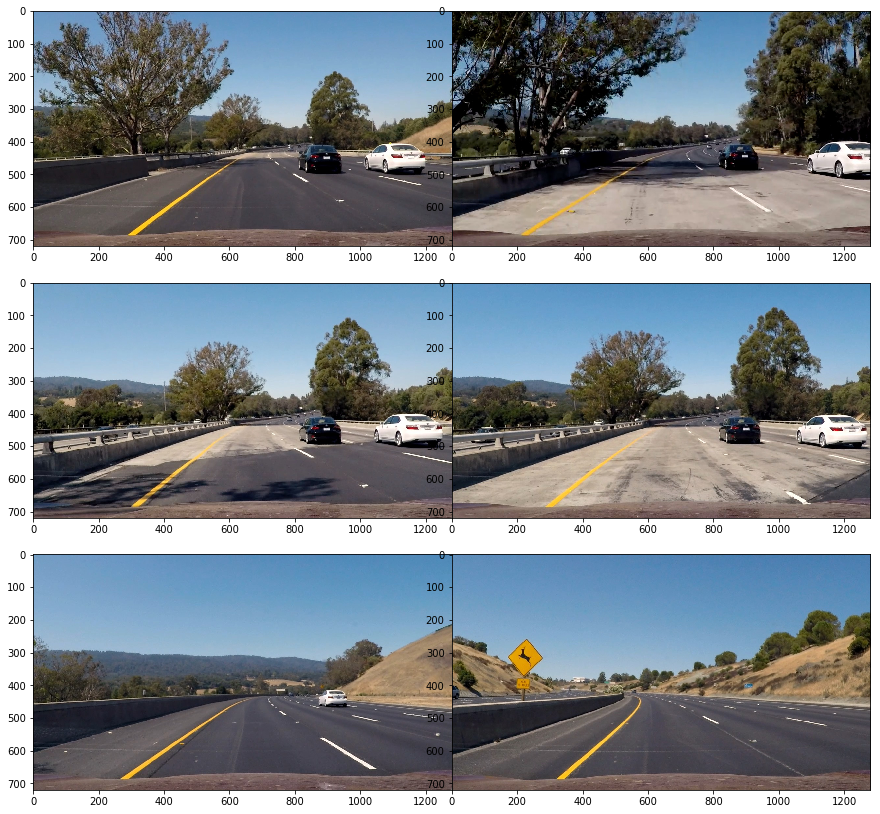

In [39]:
test_images_names = glob.glob('test_images/test*.jpg')
# Visualize test images
grid_spec = gridspec.GridSpec(3,2)
fig = plt.figure(figsize = (15,15))
for i in range(3):
    for j in range(2):
        plt.subplot(grid_spec[i,j])
        test_image = mpimg.imread(test_images_names[i*2+j])
        plt.imshow(test_image)
grid_spec.update(wspace=0, hspace=0) # set the spacing between axes. 

### Slide window implementation

In [40]:
# Verbatim from lectures
# draw_boxes function from the previous exercise
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy
    
    
# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

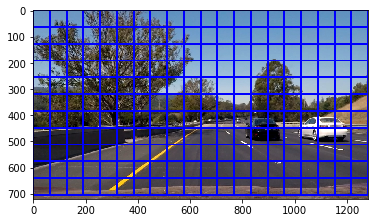

In [41]:
image = mpimg.imread(test_images_names[0])
windows = slide_window(image, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(128, 128), xy_overlap=(0.5, 0.5))
                       
window_img = draw_boxes(image, windows, color=(0, 0, 255), thick=6)                    
plt.imshow(window_img)

# Search and classify

In [55]:
spatial = 16
histbin = 32

In [56]:
# Adapted from lectures
# function to extract features from a single image window
# This function is very similar to extract_features()
# just for a single image rather than list of images
def single_img_features(img, color_space ='RGB', spatial_size=(spatial, spatial),
                        hist_bins=histbin, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel='ALL',
                        spatial_feat=True, hist_feat=True, hog_feat=True):    
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
        
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)

    #9) Return concatenated array of features
    return np.concatenate(img_features)

In [57]:
# Adapted from lectures
# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(spatial, spatial), hist_bins=histbin, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space =color_space,
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows

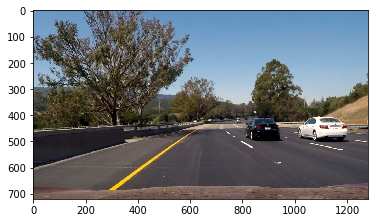

In [58]:
image = mpimg.imread(test_images_names[0])
plt.imshow(image)

color_space ='YCrCb'
orient = 9  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
spatial_size = (16, 16) # Spatial binning dimensions
hist_bins = 32    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off
y_start_stop = [None, None] # Min and max in y to search in slide_window()

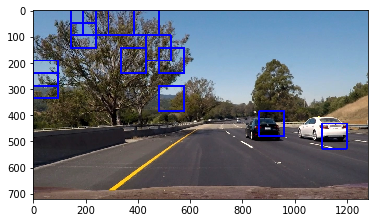

In [59]:
draw_image = np.copy(image)

# Uncomment the following line if you extracted training
# data from .png images (scaled 0 to 1 by mpimg) and the
# image you are searching is a .jpg (scaled 0 to 255)
image = image.astype(np.float32)/255

windows = slide_window(image, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(96, 96), xy_overlap=(0.5, 0.5))

hot_windows = search_windows(image, windows, svc, X_scaler, color_space=color_space,
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)                       

window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)                    

plt.imshow(window_img)

### Hog Sub-sampling Window Search

In [64]:
# Adapted from lecture
# Define a single function that can extract features using hog sub-sampling and make predictions
# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins,\
             visualize = True):
    
    # array of rectangles where cars were detected
    rectangles = []
    
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2YUV)
    
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step + 1
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step + 1
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))
            
            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)
            
            #print(spatial_features.shape,hist_features.shape, hog_features.shape )
            
            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                rectangles.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))
                cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
    if visualize == True:
        return draw_img
    else:
        return rectangles

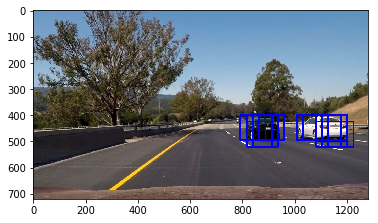

In [65]:
ystart = 400
ystop = 656
scale = 1.5

image = mpimg.imread(test_images_names[0])
    
out_img = find_cars(image, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)

plt.imshow(out_img)

In [66]:
image_boxes = []

for img in test_images_names:
    image_boxes.append(find_cars(mpimg.imread(img), ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)) 

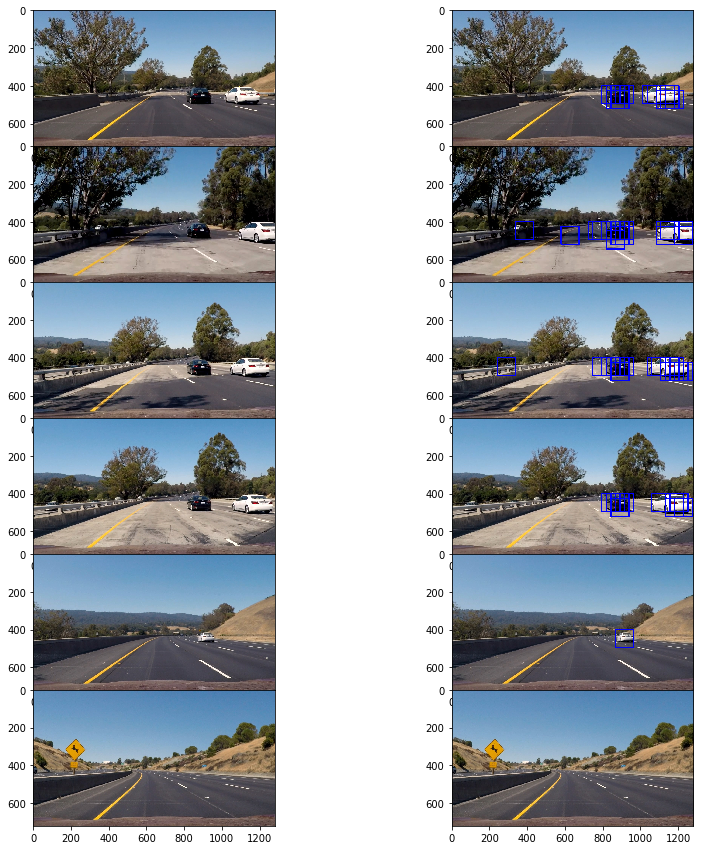

In [67]:
# Visualize vehicle images
grid_spec = gridspec.GridSpec(6,2)
fig = plt.figure(figsize = (15,15))
for i in range(6):
        plt.subplot(grid_spec[i,0])
        plt.imshow(mpimg.imread(test_images_names[i]))
        plt.subplot(grid_spec[i,1])
        plt.imshow(image_boxes[i])

plt.subplots_adjust(wspace=0, hspace=0) 

## Multiple detections and false positives

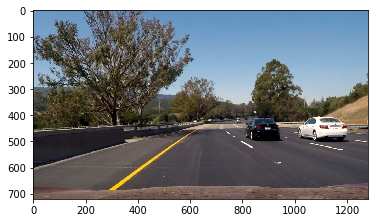

In [68]:
image = mpimg.imread(test_images_names[0])
plt.imshow(image)

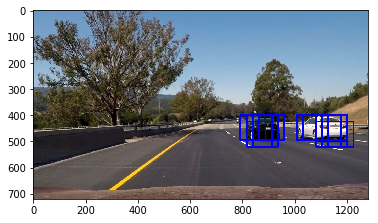

In [69]:
ystart = 400
ystop = 656
scale = 1.5
    
out_img = find_cars(image, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)

plt.imshow(out_img)

In [70]:
# adapted from lectures

def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes

def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

In [71]:
bbox_list = find_cars(image, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block,\
                      spatial_size, hist_bins, visualize = False)

In [72]:
heat = np.zeros_like(image[:,:,0]).astype(np.float)
heatmap = add_heat(heat, bbox_list)

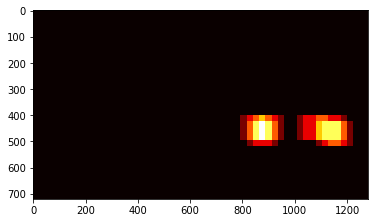

In [73]:
# show heatmap
plt.imshow(heatmap, cmap='hot')

2 cars found


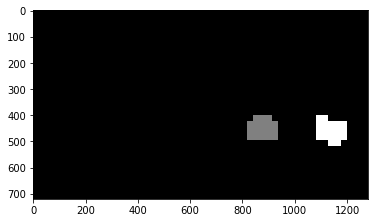

In [74]:
heatmap = apply_threshold(heatmap, 2)
labels = label(heatmap)
print(labels[1], 'cars found')
plt.imshow(labels[0], cmap='gray')

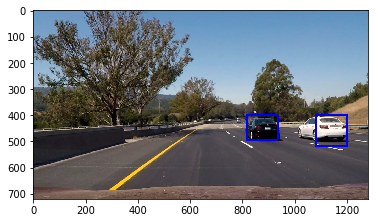

In [75]:
# Draw bounding boxes on a copy of the image
draw_img = draw_labeled_bboxes(np.copy(image), labels)
# Display the image
plt.imshow(draw_img)

## Process video

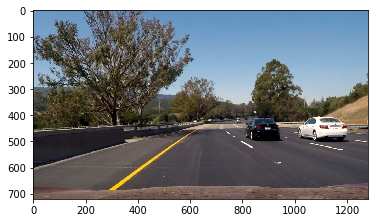

In [76]:
plt.imshow(image)

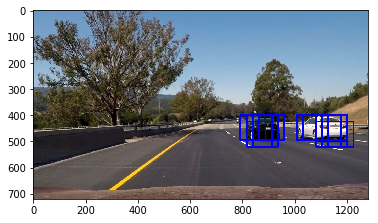

In [77]:
out_img = find_cars(image, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)

plt.imshow(out_img)

In [82]:
ystart = 400
ystop = 656
scale = 1.5
color_space ='YCrCb'
orient = 9  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
spatial_size = (16, 16) # Spatial binning dimensions
hist_bins = 32    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off
y_start_stop = [None, None] # Min and max in y to search in slide_window()

In [91]:
# class to store data from video
class vehicle_detection():
    def __init__(self):
        # save rectangles from previous frames
        self.previous_rectangles = []         
    def add_rectangles(self, rectangles):
        self.previous_rectangles.append(rectangles)
        if len(self.previous_rectangles) > 10:
            # throw out oldest rectangle set(s)
            self.previous_rectangles = self.previous_rectangles[len(self.previous_rectangles)-10:]

In [92]:
def process_image(image):
    
    draw_image = np.copy(image)

    scale = 1.0
    
    bbox_list = find_cars(image, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block,\
                      spatial_size, hist_bins, visualize = False)
    scale = 1.5
    
    bbox_list.extend(find_cars(image, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block,\
                      spatial_size, hist_bins, visualize = False))
    scale = 2.0
    
    bbox_list.extend(find_cars(image, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block,\
                      spatial_size, hist_bins, visualize = False))
#   scale = 3.5
    
#   bbox_list.extend(find_cars(image, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block,\
#                   spatial_size, hist_bins, visualize = False))
    
    # add detections to the history
    if len(bbox_list) > 0:
        detection.add_rectangles(bbox_list)
        
    heatmap = np.zeros_like(image[:,:,0]).astype(np.float)
    
    for rectangle in detection.previous_rectangles:
        heatmap = add_heat(heatmap, rectangle)
    heatmap = apply_threshold(heatmap,1 + len(detection.previous_rectangles)//2)
    labels = label(heatmap)
    # Draw bounding boxes on a copy of the image
    draw_img = draw_labeled_bboxes(draw_image, labels)

#   heat = np.zeros_like(image[:,:,0]).astype(np.float)
#   heatmap = add_heat(heat, bbox_list)
#   heatmap = apply_threshold(heatmap, 4)
#   labels = label(heatmap)
#   # Draw bounding boxes on a copy of the image
#    draw_img = draw_labeled_bboxes(np.copy(image), labels)

    # Display the image
    return draw_img 

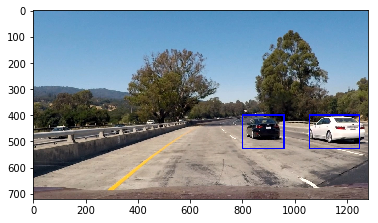

In [93]:
detection = vehicle_detection()
image = mpimg.imread(test_images_names[3])
plt.imshow(process_image(image))

In [94]:
detection = vehicle_detection()
# test pipeline on short video
Output_video = 'test_video_output.mp4'
Input_video = 'test_video.mp4'

clip1 = VideoFileClip(Input_video)
video_clip = clip1.fl_image(process_image) # this function expects color images
video_clip.write_videofile(Output_video, audio = False)

[MoviePy] >>>> Building video test_video_output.mp4
[MoviePy] Writing video test_video_output.mp4


 97%|█████████▋| 38/39 [00:58<00:01,  1.56s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_video_output.mp4 



In [95]:
# test pipeline on short video
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format('test_video_output.mp4'))

## Video pipeline

In [96]:
# test pipeline on full video
detection = vehicle_detection()
Output_video = 'project_video_output.mp4'
Input_video = 'project_video.mp4'

clip = VideoFileClip(Input_video)
#test_clip = clip.subclip(20,25)
video_clip = clip.fl_image(process_image) # this function expects color images
video_clip.write_videofile(Output_video, audio = False)

[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


100%|█████████▉| 1260/1261 [33:22<00:01,  1.56s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 



In [97]:
# test pipeline on short video
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format('project_video_output.mp4'))